## WorkSheet 9

**Q.1) Here the function h\* would be:**


class 1 for -1 < x < 0, since between P(x|y=1) = 7/8 * 1/4 = 7/24 is greatest in this range.

class 3 for 0 < x < 1, since P(x|y=3) = 1/2 * 1/2 = 1/4 is greatest in this range

**Q.4) Below is the classification code.**

In [1]:
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):
    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [2]:
from scipy.stats import multivariate_normal


**Q4. a) Loading the training images and labels:**

In [3]:
x,y = loadmnist('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')

In [4]:
print("Length of x :"+str(len(x))+ " Length of y :"+str(len(y)))

Length of x :60000 Length of y :60000


Testing the displaychar method:

Splitting the training images into 50k training and 10k validation images:

Loading Test Data:

In [5]:
x_test_images,y_test_labels = loadmnist('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

In [50]:
y_test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

**Q4. b) Splitting the data into training and validation set**

In [6]:
#putting a random state to make the split more consistent and using sklearn train_test_split to do the separation
import numpy as np
from sklearn.model_selection import train_test_split
X_train_images, X_validation_images, y_train_labels, y_validation_labels = train_test_split(x, y, train_size=50000,random_state=10)

**Q4. c) part 1 -  The class probabilities**

In [7]:
#This portion calculates the proportion or the class(digit) probabilities
piDict = {}

for i in range(10):
    fraction = y_train_labels.tolist().count(i)/len(y_train_labels)
    piDict[i] = y_train_labels.tolist().count(i)/len(y_train_labels)
    print("The probability of digit "+str(i)+" is "+str(fraction))

The probability of digit 0 is 0.09986
The probability of digit 1 is 0.11276
The probability of digit 2 is 0.0984
The probability of digit 3 is 0.10306
The probability of digit 4 is 0.09678
The probability of digit 5 is 0.08998
The probability of digit 6 is 0.09852
The probability of digit 7 is 0.10268
The probability of digit 8 is 0.0977
The probability of digit 9 is 0.10026


In [8]:
#This method gives a matrix of image for corresponding class/digit label.
def getImageMatrixForDigit(digit):
    idxs = np.where(y_train_labels == digit)
    return X_train_images[idxs]

In [9]:
#This routine needs the value of constant c , the images and labels data set you want to predict labels for
def getActualAndPredictedLabels(c_val,images_dataset,labels_dataset):
    digitMeanCovDict = {}
    for i in range(10):
        digit_mtrx = getImageMatrixForDigit(i)
        digit_mean = digit_mtrx.mean(0)
        digit_cov = np.cov(digit_mtrx,rowvar=False)
        id_mtrx = np.identity(784)*c_val
        smoothCov = np.add(digit_cov,id_mtrx)
        digitMeanCovDict[i] = [digit_mtrx,digit_mean,smoothCov]
    
    logpdf_dictionary = {}
    for j in range(10):
            logPi = np.log(piDict[labels_dataset[j]])
            logPDFVal = multivariate_normal.logpdf(images_dataset, mean=digitMeanCovDict[j][1], cov=digitMeanCovDict[j][2])
            finalLogPDF = logPi + logPDFVal
            logpdf_dictionary[j] = finalLogPDF
            
            
    validation_prediction = []
    for i in range(len(labels_dataset)):
        digit_dict = {}
        for j in range(10):
            digit_dict[j] = logpdf_dictionary[j][i]
        max_logpdf_digit = max(digit_dict, key=digit_dict.get)
        validation_prediction.append((labels_dataset[i],max_logpdf_digit))

    return validation_prediction
    

In [10]:
#This method takes the list of tuple(actual lable, predicted label) and calculates the error rate for that predicted set.
def calculateErrorRate(actualAndPredictedLabels):
    match=filter(lambda x: x[0] == x[1], actualAndPredictedLabels)
    nomatch=filter(lambda x: x[0] != x[1], actualAndPredictedLabels)
    match_cnt = len(list(match))
    nomatch_cnt = len(list(nomatch))
    #print("c="+str(c_val))
    return nomatch_cnt/len(y_validation_labels)
    

Let's try different values of c to make the covariance matrix smooth

**Q4. d) Finding the constant c value for smoothing the covariance matrix.Smooth cov = cov + c x Identity Matrix.**

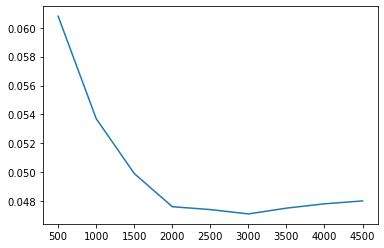

In [11]:
#c_val and error rate dictionary to plot a graph. I am trying c values starting from 500 to 5000 in increments of 500.
c_val_and_err_rate_dict = {}
for c_val in range(500, 5000, 500):
    actualAndPredictedLabels = getActualAndPredictedLabels(c_val,X_validation_images,y_validation_labels)
    err_rt = calculateErrorRate(actualAndPredictedLabels)
    c_val_and_err_rate_dict[c_val] = err_rt
    
import matplotlib.pyplot as plt
plt.plot(c_val_and_err_rate_dict.keys(), c_val_and_err_rate_dict.values())

From the above graph c = 3000 is giving the least error rate or you can say the highest accuracy.

**Q4. c) part 2 - From above experiment I have arrived at c = 3000 for best fitting. Hence I am calculating the mean and smoothed covariance matrix part here.**

In [12]:
digitMeanCovDict = {}
for i in range(10):
    digit_mtrx = getImageMatrixForDigit(i)
    digit_mean = digit_mtrx.mean(0)
    digit_cov = np.cov(digit_mtrx,rowvar=False)
    id_mtrx = np.identity(784)*3000
    smoothCov = np.add(digit_cov,id_mtrx)
    digitMeanCovDict[i] = [digit_mtrx,digit_mean,smoothCov]


**digitMeanCovDict python dictionary had this format {"digit":(digit image matrix, mean vector, smoothed covariance matrix)}**

**Q4. e) part 2 - Error rate on the MNIST test set**

In [13]:
#Error rate for test data
testActualAndPredictedLabels = getActualAndPredictedLabels(3000,x_test_images,y_test_labels)
err_rt = calculateErrorRate(testActualAndPredictedLabels)
print("Error rate for test dataset with our model is : "+str(err_rt))

Error rate for test dataset with our model is : 0.0434


**Q4. e) part 3 - Out of the misclassified test digits, pick five at random and display them. For each instance,
list the posterior probabilities Pr(y|x) of each of the ten classes.**

In [14]:
#pick all wrongly classified labels

def condition(x): return x[0] != x[1] # this condition checks in my list of (actual label, predicted label about their inequality)
incorrect_predicted_image_idxs = [idx for idx, element in enumerate(testActualAndPredictedLabels) if condition(element)]

In [15]:
#pick 5 out of the above labels
import random
incorect_predictions_5 = random.sample(incorrect_predicted_image_idxs, 5)

In [16]:
#Trying to verify indexes for incorrectly predicted labels
incorect_predictions_5

[4671, 667, 4771, 1364, 2532]

Index of incorrectly classified image: 4671
Test Digit :8, Predicted Digit: 3
The log values of Pi(j).Pj(x) : -4065.8704417288027

Image Display:


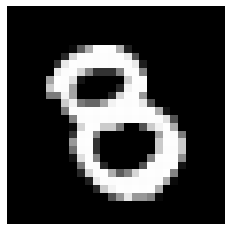

----------------------------

Index of incorrectly classified image: 667
Test Digit :7, Predicted Digit: 1
The log values of Pi(j).Pj(x) : -4000.463171361502

Image Display:


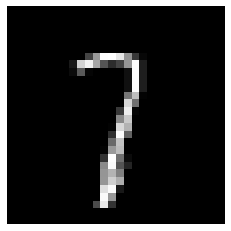

----------------------------

Index of incorrectly classified image: 4771
Test Digit :5, Predicted Digit: 8
The log values of Pi(j).Pj(x) : -4054.1208702769773

Image Display:


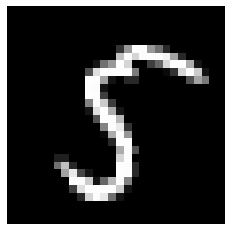

----------------------------

Index of incorrectly classified image: 1364
Test Digit :8, Predicted Digit: 2
The log values of Pi(j).Pj(x) : -4100.173527609115

Image Display:


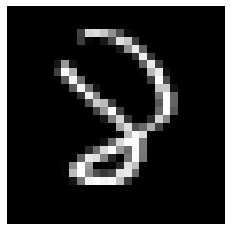

----------------------------

Index of incorrectly classified image: 2532
Test Digit :6, Predicted Digit: 1
The log values of Pi(j).Pj(x) : -4001.914554323278

Image Display:


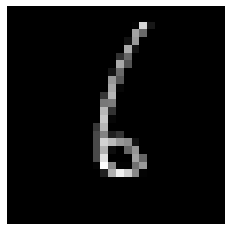

----------------------------



In [17]:
for idx in incorect_predictions_5:
    print("Index of incorrectly classified image: "+str(idx))
    test_digit = testActualAndPredictedLabels[idx][0]
    print("Test Digit :"+str(test_digit)+", Predicted Digit: "+str(testActualAndPredictedLabels[idx][1]))
    logPi = np.log(piDict[test_digit])
    logPDFVal = multivariate_normal.logpdf(x_test_images[idx], mean=digitMeanCovDict[test_digit][1], cov=digitMeanCovDict[test_digit][2])
    finalLogPDF = logPi + logPDFVal
    print("The log values of Pi(j).Pj(x) : "+str(finalLogPDF))
    print("\nImage Display:")
    displaychar(x_test_images[idx])
    print("----------------------------\n")
 

## Worksheet 10 

**Q.1) Data set given  -10, -8, 0, 8, 10**

    Need to be clustered into k = 3 groups.

**Q1.a) The optimal k-measn solution should have below centres**
        
        First center = -9 i.e mean of 1st cluster
        Second center = 0  i.e mean of 2ndt cluster
        Third center = 9 i.e mean of 3rd cluster
        
        Cost = sqr(||-9-(-10)||) + sqr||-9-(-8)|| + sqr(||0||) + sqr(||9-8||) + + sqr(||9-10||)
            =  1 + 1 + 0 + 1 + 1
            =  4

**Q1.b) Lloyds's k-means on this data with k = 3**
        
        mean1 = -10 , mean2 = -8 and mean3 = 0
        
        There are three clusters set here :
        cluster 1 -> -10 
        cluster 2 -> -8
        cluster 3 -> [0 8 10]
        
        Initial cluster cost = sqr(||0||) + sqr||0|| + sqr(||0||) + sqr(||0-8||) + + sqr(||0-10||)
                             = 0 + 0 + 0 + 64 + 100
                             = 164
        
        Final set of clusters would be as below 
        cluster 1 -> -10  with center -10
        cluster 2 -> -8 with center -8 
        cluster 3 -> [0 8 10] with centre = 6 i.e mean of 0 , 8 , 10
        
        So we are able to get minimum cost in one iteration of convering clusters into their mean as centers.
        
        Final Cost = sqr(||0||) + sqr||0|| + sqr(||6-0||) + sqr(||6-8||) + + sqr(||6-10||)
             = 0 + 0 + 36 + 4 + 16
             = 56
        
        
        

**Q.2. a) Loading the data**

In [27]:
import numpy
realvalues = numpy.loadtxt("Animals_with_Attributes/predicate-matrix-continuous.txt")
realvalues

array([[-1.  , -1.  , -1.  , ...,  2.35,  9.7 ,  8.38],
       [39.25,  1.39,  0.  , ..., 58.64, 20.14, 11.39],
       [83.4 , 64.79,  0.  , ..., 15.77, 13.41, 15.42],
       ...,
       [63.57, 43.1 ,  0.  , ..., 35.95, 28.26,  5.  ],
       [55.31, 55.46,  0.  , ...,  5.04, 18.89, 72.99],
       [10.22, 21.53, 27.73, ...,  3.96, 14.05, 37.98]])

In [29]:
realvalues.shape

(50, 85)

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10,init='k-means++', random_state=0).fit(realvalues)

In [30]:
#Trying to predict the labels.
kmeans.fit_predict(realvalues)

array([0, 9, 2, 8, 4, 4, 0, 4, 2, 4, 3, 3, 1, 5, 1, 0, 6, 2, 5, 6, 5, 1,
       5, 8, 6, 3, 3, 5, 3, 7, 0, 1, 4, 3, 1, 8, 5, 0, 5, 0, 1, 5, 1, 3,
       9, 4, 2, 3, 5, 2], dtype=int32)

In [21]:
#creating a labels dataframe for merge with animals df
import pandas as pd
labels_arr = kmeans.labels_
labels_df = pd.DataFrame(data=labels_arr,  columns=["label"])


In [22]:
#loading the animal names in a dataframe
import pandas
animalnames = pandas.read_csv("Animals_with_Attributes/classes.txt",sep="\t",names=["index","animal"])
#animalnames = numpy.loadtxt("Animals_with_Attributes/classes.txt",delimiter="\t")
animalnames.drop("index", axis=1, inplace=True)
#animalnames

In [23]:
#Merging clustered labels and animals df to form groupings of animals for the clusters
merged_df = pd.merge(animalnames, labels_df, left_index=True, right_index=True)
merged_df.groupby('label')

In [24]:
#Lets verify the cluster groupings makes sense or not ?
for animal, label_group in merged_df.groupby('label'):
    print(animal)
    print(label_group)

0
      animal  label
0   antelope      0
6      horse      0
15     moose      0
30   giraffe      0
37     zebra      0
39      deer      0
1
     animal  label
12    tiger      1
14  leopard      1
21      fox      1
31     wolf      1
34   weasel      1
40   bobcat      1
42     lion      1
2
            animal  label
2     killer+whale      2
8       blue+whale      2
17  humpback+whale      2
46          walrus      2
49         dolphin      2
3
      animal  label
10     skunk      3
11      mole      3
25   hamster      3
26  squirrel      3
28    rabbit      3
33       rat      3
43     mouse      3
47   raccoon      3
4
             animal  label
4         dalmatian      4
5       persian+cat      4
7   german+shepherd      4
9       siamese+cat      4
32        chihuahua      4
45           collie      4
5
          animal  label
13  hippopotamus      5
18      elephant      5
20            ox      5
22         sheep      5
27    rhinoceros      5
36       buffalo      5
38 

From the above groupings, it is clear that the clusters and grouping are good to certain extend. Take example of the cluster with label = 6 where spider monkey, gorilla and chimpanzee have been clustered together.

**Q2. b) Hierarchical Clustering**

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
Z = linkage(realvalues, 'ward')

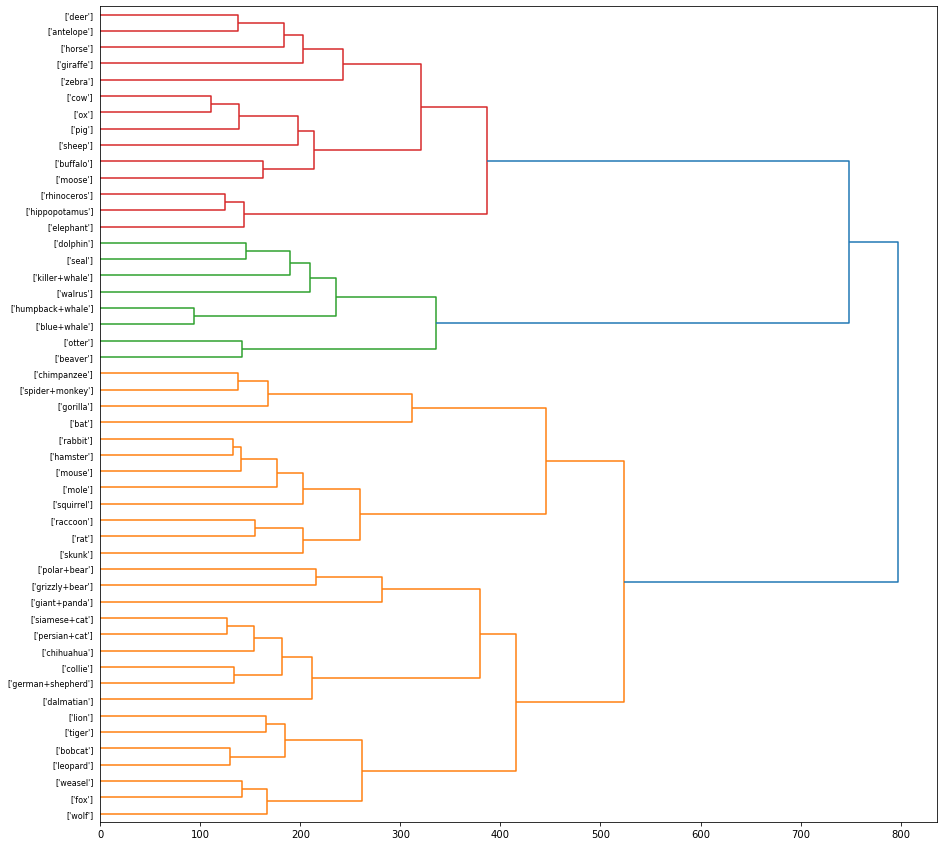

In [26]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
dn = dendrogram(Z,orientation='right',labels=animalnames.values.tolist())
plt.show()

The above dendrogram makes sense in terms of the grouping it has done. So the hierarchical clustering is sensible here.

**Q2. c) All the observations are present as markdown cells in earlier two parts . Thanks**

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


In [39]:
reduced_X = pca.fit_transform(realvalues)

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10,init='k-means++', random_state=0)

In [43]:
reduced_labels_arr = kmeans.fit_predict(reduced_X)

In [44]:
reduced_labels_df = pd.DataFrame(data=reduced_labels_arr,  columns=["label"])

In [45]:
#Merging clustered labels and animals df to form groupings of animals for the clusters
merged_reduced_df = pd.merge(animalnames, reduced_labels_df, left_index=True, right_index=True)
merged_reduced_df.groupby('label')

In [46]:
#Lets verify the cluster groupings makes sense or not ?
for animal, label_group in merged_reduced_df.groupby('label'):
    print(animal)
    print(label_group)

0
     animal  label
12    tiger      0
14  leopard      0
21      fox      0
31     wolf      0
40   bobcat      0
1
         animal  label
25      hamster      1
28       rabbit      1
38  giant+panda      1
43        mouse      1
2
            animal  label
8       blue+whale      2
17  humpback+whale      2
46          walrus      2
3
      animal  label
18  elephant      3
20        ox      3
36   buffalo      3
41       pig      3
48       cow      3
4
             animal  label
1      grizzly+bear      4
7   german+shepherd      4
9       siamese+cat      4
29              bat      4
32        chihuahua      4
33              rat      4
34           weasel      4
42             lion      4
47          raccoon      4
5
        animal  label
3       beaver      5
35       otter      5
44  polar+bear      5
6
           animal  label
4       dalmatian      6
5     persian+cat      6
10          skunk      6
11           mole      6
16  spider+monkey      6
19        gorilla      6
